In [39]:
import os
os.environ["SAFETENSORS_FAST_SAVE"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

import random
import shutil
from pathlib import Path

import json

import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import segmentation_models_pytorch as smp           

import albumentations as A

In [40]:
project_root = Path.cwd() / "DATASET"

In [41]:
def split_data(root_dir: str, split_ratio=0.8):
    root = Path(root_dir)
    seg_dir = root / "Segmentation"

    pairs = []
    for tumor_type in seg_dir.iterdir():
        for mask_path in tumor_type.glob("*_mask.png"):
            base_stem = mask_path.stem[:-5]
            img_path = tumor_type / f"{base_stem}.png"
            pairs.append((img_path, mask_path))

    print(f"Found {len(pairs)} image–mask pairs.")

    random.shuffle(pairs)
    split_idx = int(len(pairs) * split_ratio)
    train_pairs = pairs[:split_idx]
    val_pairs = pairs[split_idx:]

    for split in ["train", "val"]:
        (root / split / "images").mkdir(parents=True, exist_ok=True)
        (root / split / "masks").mkdir(parents=True, exist_ok=True)

    def copy_pairs(pairs, split_name):
        for img_path, mask_path in pairs:
            shutil.copy(img_path, root / split_name / "images" / img_path.name)
            shutil.copy(mask_path, root / split_name / "masks" / mask_path.name)

    copy_pairs(train_pairs, "train")
    copy_pairs(val_pairs, "val")

    print(f"Split {len(train_pairs)} train and {len(val_pairs)} val samples.")
    print(f" Training data:  → {root/'train'}")
    print(f" Validation data:  → {root/'val'}")

if not ((project_root / "train").exists() and (project_root / "val").exists()):
    split_data(project_root)

Found 2192 image–mask pairs.
Split 1753 train and 439 val samples.
 Training data:  → /Users/adam/deep-machine-learning/Project/DATASET/train
 Validation data:  → /Users/adam/deep-machine-learning/Project/DATASET/val


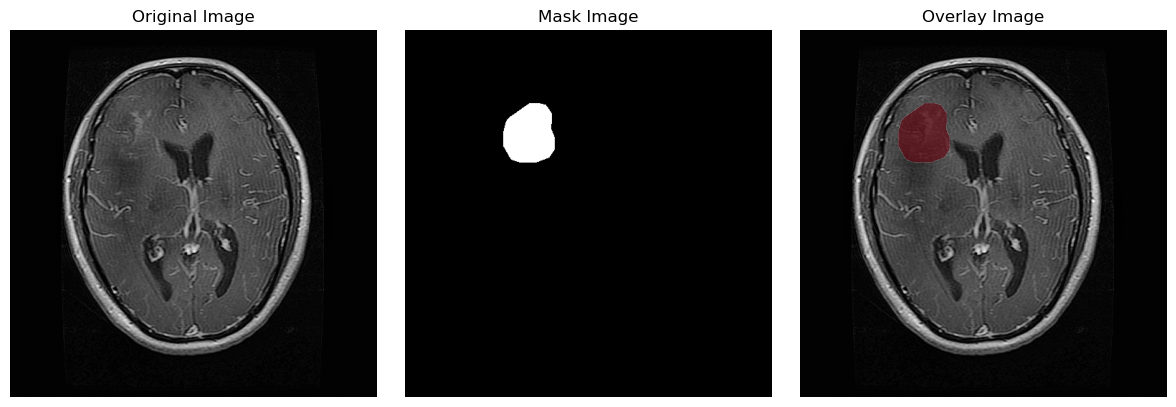

In [42]:
def plot_image_and_mask(index: int, split: str = "train"):
    images_dir = project_root / split / "images"
    masks_dir  = project_root / split / "masks"

    img_path  = sorted(images_dir.glob("*.png"))[index]
    mask_path = masks_dir / f"{img_path.stem}_mask.png"

    img  = np.array(Image.open(img_path))
    mask = (np.array(Image.open(mask_path)) > 127).astype(float)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="Reds", alpha=0.6 * mask)
    plt.title("Overlay Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_image_and_mask(754, split="train")



In [43]:
IMG_SIZE   = (512, 512)
BATCH_SIZE = 16
EPOCHS     = 100
BASE_CH    = 32
LR         = 0.001
PROJECT_ROOT = project_root

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

Device: mps


In [44]:
class DSConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 1, 1, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.seq(x)

class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DSConvBlock(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        s = self.conv(x)
        return self.pool(s), s

class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.conv = DSConvBlock(out_ch * 2, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
        return self.conv(torch.cat([x, skip], dim=1))

class BrainTumorSegmentationModel(nn.Module):

    def __init__(self, in_ch=1, out_ch=1, base=BASE_CH):
        super().__init__()
        self.d1 = Encoder(in_ch,base)
        self.d2 = Encoder(base,base*2)
        self.d3 = Encoder(base*2,base*4)
        self.d4 = Encoder(base*4,base*8)

        self.bottleneck = DSConvBlock(base * 8, base * 16)

        self.u4 = Decoder(base*16,base*8)
        self.u3 = Decoder(base*8,base*4)
        self.u2 = Decoder(base*4,base*2)
        self.u1 = Decoder(base*2,base)

        self.head = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x, s1 = self.d1(x)
        x, s2 = self.d2(x)
        x, s3 = self.d3(x)
        x, s4 = self.d4(x)
        x = self.bottleneck(x)
        x = self.u4(x,s4)
        x = self.u3(x,s3)
        x = self.u2(x,s2)
        x = self.u1(x,s1)
        return self.head(x)

In [45]:
def _simulate_mri_contrast(img: np.ndarray, **kwargs) -> np.ndarray:

    g = img.astype(np.float32) / 255.0

    mode = np.random.choice(["T1", "T2", "FLAIR"])
    gamma_lo = {"T1": 0.8, "T2": 0.9, "FLAIR": 1.0}[mode]
    gamma_hi = {"T1": 1.2, "T2": 1.3, "FLAIR": 1.4}[mode]
    gamma = np.random.uniform(gamma_lo, gamma_hi)

    if mode == "FLAIR":
        g = g / (1.0 + np.exp(8.0 * (g - 0.85))) 

    if mode != "T1":
        g = 1.0 - g  

    g = np.power(np.clip(g, 0.0, 1.0), gamma)

    g8 = np.uint8(np.clip(g * 255.0, 0, 255))
    g8 = cv2.createCLAHE(
        clipLimit=np.random.uniform(1.5, 3.0),
        tileGridSize=(8, 8)
    ).apply(g8)

    return g8  


def get_transforms(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Lambda(image=_simulate_mri_contrast, p=0.7),
        ])
    else:
        return A.Compose([])


class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, resize=None, preload=True, transform=None, name=""):
        self.imgs = sorted(Path(img_dir).glob("*.png"))
        self.mask_dir = Path(mask_dir)
        self.resize = resize
        self.transform = transform
        self.name = name

        self.data = [self._read(p) for p in tqdm(self.imgs, desc=f"Preload {self.name}", leave=False)]

    def _read(self, p):
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.resize, interpolation=cv2.INTER_LINEAR)

        mpath = self.mask_dir / f"{p.stem}_mask.png"
        m = Image.open(mpath).convert("L")
        m = m.resize(self.resize, resample=Image.NEAREST)
        mask = (np.array(m) > 127).astype(np.uint8)

        return img, mask

    def __getitem__(self, i):
        img, mask = self.data[i]
        if self.transform:
            out = self.transform(image=img, mask=mask)
            img, mask = out["image"], out["mask"]

        img_t = torch.from_numpy(img).unsqueeze(0).float() / 255.0  
        mask_t = torch.from_numpy(mask).unsqueeze(0).float()
        return img_t, mask_t, self.imgs[i].name

    def __len__(self):
        return len(self.imgs)




In [46]:
dice_loss_fn = smp.losses.DiceLoss(mode="binary", from_logits=True)
bce_loss_fn  = smp.losses.SoftBCEWithLogitsLoss()

@torch.no_grad()
def dice_metric(preds, targets, threshold=0.5, eps=1e-6):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return (2 * intersection + eps) / (union + eps)


def build_loaders(root=PROJECT_ROOT, batch=BATCH_SIZE):
    tr = SegmentationDataset(f"{root}/train/images", f"{root}/train/masks",
                             resize=IMG_SIZE, preload=True, transform=get_transforms(True),  name="train")
    va = SegmentationDataset(f"{root}/val/images",   f"{root}/val/masks",
                             resize=IMG_SIZE, preload=True, transform=get_transforms(False), name="val")
    trL = DataLoader(tr, batch_size=batch, shuffle=True)
    vaL = DataLoader(va, batch_size=batch, shuffle=False)
    return trL, vaL

def make_transfer_unet(encoder="resnet34", in_ch=1, out_ch=1, weights="imagenet"):
    return smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,   
        in_channels=in_ch,
        classes=out_ch,
        activation=None
    )

def freeze_encoder(model, freeze=True):
    if hasattr(model, "encoder"):
        for p in model.encoder.parameters():
            p.requires_grad = not freeze


def make_discriminative_opt(model, lr_body, lr_head, weight_decay=1e-4):
    enc = list(model.encoder.parameters())
    dec = [p for n, p in model.named_parameters() if not n.startswith("encoder.")]
    return torch.optim.AdamW(
        [{"params": enc, "lr": lr_body},
         {"params": dec, "lr": lr_head}],
        weight_decay=weight_decay
    )




In [47]:
def run_epoch(model, loader, opt=None, phase_name="Train"):
    train = opt is not None
    model.train(train)

    total_loss, total_dice = 0.0, 0.0
    device_type = device.type
    use_amp = device_type == "cuda"   

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    for imgs, masks, _ in tqdm(
        loader,
        leave=False,
        dynamic_ncols=False,
        disable=False,
        desc=phase_name
    ):
        imgs, masks = imgs.to(device), masks.to(device)

        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model(imgs)
            loss = 0.3 * dice_loss_fn(out, masks) + 0.7 * bce_loss_fn(out, masks)

        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

        total_loss += loss.item()
        total_dice += dice_metric(out, masks).item()

    avg_loss = total_loss / len(loader)
    avg_dice = total_dice / len(loader)

    return avg_loss, avg_dice


def train_eval(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, tag="model",
               epoch_freeze=0, use_discriminative_lr=False, root=PROJECT_ROOT):
    model = model.to(device)

    if use_discriminative_lr:
        opt = make_discriminative_opt(model, lr_body=lr * 0.1, lr_head=lr)
    else:
        opt = torch.optim.AdamW(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=3)

    model.history = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}

    best_val = float("inf")
    best_path = f"{root}/{tag}.pt"
    hist_path = f"{root}/{tag}.json"

    freeze_encoder(model, True)

    print(f"{'='*80}")
    print(f"{tag}")
    print(f"{'='*80}\n")

    for e in range(1, epochs + 1):
        if epoch_freeze and e == epoch_freeze + 1:
            freeze_encoder(model, False)

        tr_loss, tr_dice = run_epoch(model, train_loader, opt,  phase_name=f"{tag} Train {e:02d}")
        va_loss, va_dice = run_epoch(model, val_loader,   None, phase_name=f"{tag} Val   {e:02d}")

        model.history["train_loss"].append(float(tr_loss))
        model.history["train_dice"].append(float(tr_dice))
        model.history["val_loss"].append(float(va_loss))
        model.history["val_dice"].append(float(va_dice))

        print(f"[Epoch {e:02d}] training_loss={tr_loss:.4f} val_loss={va_loss:.4f} | training_dice={tr_dice:.4f} val_dice={va_dice:.4f}")

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), best_path)

        scheduler.step(va_loss)

        with open(hist_path, "w") as f:
            json.dump(model.history, f, indent=2)

    return model, best_path

In [ ]:
trL, vaL = build_loaders(PROJECT_ROOT)

scratch = BrainTumorSegmentationModel(1, 1, BASE_CH)
scratch, scratch_path = train_eval(scratch, trL, vaL, epochs=EPOCHS, lr=LR, tag="U-net architecture")


transfer = make_transfer_unet(encoder="resnet34", in_ch=1, out_ch=1, weights="imagenet")
transfer, transfer_path = train_eval(transfer, trL, vaL, epochs=EPOCHS, lr=LR, tag="ResNet-34",
                                     epoch_freeze=2, use_discriminative_lr=True)



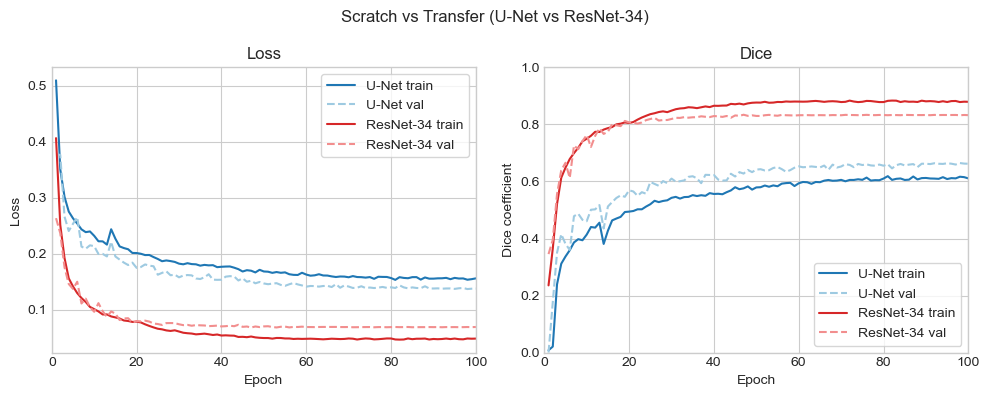

In [48]:
def load_history(path):
    with open(path, "r") as f:
        return json.load(f)

def plot_histories(files):

    histos = [(label, load_history(path)) for label, path in files]
    epochs = range(1, len(histos[0][1]["train_loss"]) + 1)

    color_pairs = {
        "U-Net":  ("#1f77b4", "#9ecae1"),    
        "ResNet-34": ("#d62728", "#f28e8e"),  
        "EfficientNet": ("#2ca02c", "#98df8a"),
        "VGG16": ("#9467bd", "#c5b0d5"),       
    }

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    for label, h in histos:
        train_c, val_c = color_pairs.get(label, ("gray", "lightgray"))
        plt.plot(epochs, h["train_loss"], color=train_c, label=f"{label} train")
        plt.plot(epochs, h["val_loss"], color=val_c, linestyle="--", label=f"{label} val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.xlim(0, 100)
    plt.legend(frameon=True)

    plt.subplot(1, 2, 2)
    for label, h in histos:
        train_c, val_c = color_pairs.get(label, ("gray", "lightgray"))
        plt.plot(epochs, h["train_dice"], color=train_c, label=f"{label} train")
        plt.plot(epochs, h["val_dice"], color=val_c, linestyle="--", label=f"{label} val")
    plt.title("Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice coefficient")
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(0, 1)  
    plt.legend(frameon=True)

    plt.suptitle("Scratch vs Transfer (U-Net vs ResNet-34)")
    plt.tight_layout()
    plt.show()

# Example usage
plot_histories([
    ("U-Net", "U-net architecture.json"),
    ("ResNet-34", "ResNet-34.json")
])


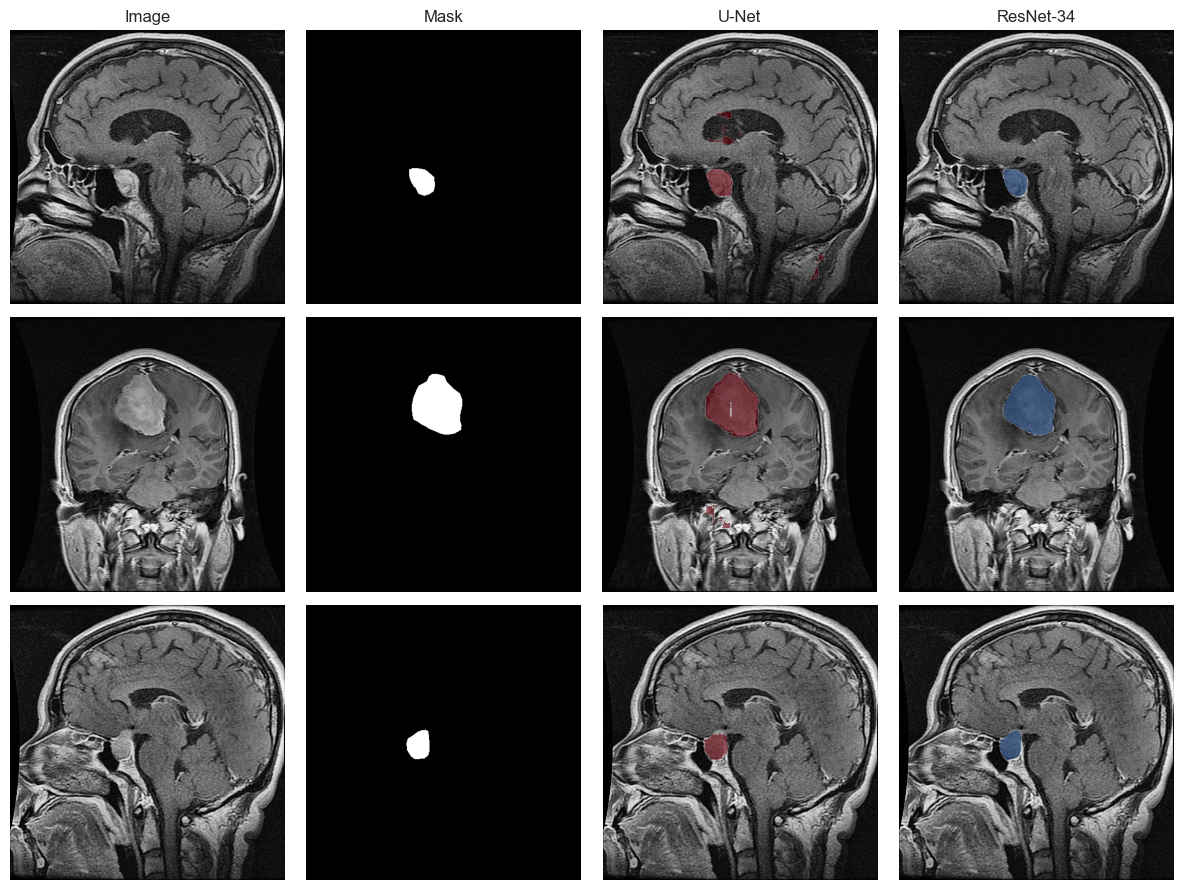

In [49]:
@torch.no_grad()
def compare_models_plot(ds, scratch_path, transfer_path, thr=0.5, idxs=[10, 50]):
    scratch_state = torch.load(scratch_path, map_location=device)
    if isinstance(scratch_state, dict) and "state_dict" in scratch_state:
        scratch_state = scratch_state["state_dict"]
    scratch_model = BrainTumorSegmentationModel(in_ch=1, out_ch=1, base=BASE_CH)
    scratch_model.load_state_dict(scratch_state)
    scratch_model.to(device).eval()

    transfer_state = torch.load(transfer_path, map_location=device)
    if isinstance(transfer_state, dict) and "state_dict" in transfer_state:
        transfer_state = transfer_state["state_dict"]
    transfer_model = smp.Unet(
        encoder_name="resnet34", encoder_weights=None,
        in_channels=1, classes=1, activation=None
    )
    transfer_model.load_state_dict(transfer_state)
    transfer_model.to(device).eval()

    n_rows = len(idxs)
    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3 * n_rows))

    for row, i in enumerate(idxs):
        img_t, mask_t, name = ds[i]
        img = img_t.permute(1,2,0).numpy().squeeze()
        gt  = mask_t.squeeze().numpy().astype(bool)

        pred_scratch = torch.sigmoid(scratch_model(img_t.unsqueeze(0).to(device))).cpu().squeeze().numpy() > thr
        pred_transfer = torch.sigmoid(transfer_model(img_t.unsqueeze(0).to(device))).cpu().squeeze().numpy() > thr

        ax = axes[row] if n_rows > 1 else axes

        ax[0].imshow(img, cmap="gray")
        ax[1].imshow(gt, cmap="gray")
        ax[2].imshow(img, cmap="gray")
        ax[2].imshow(pred_scratch, cmap="Reds", alpha=0.6*pred_scratch)
        ax[3].imshow(img, cmap="gray")
        ax[3].imshow(pred_transfer, cmap="Blues", alpha=0.6*pred_transfer)

        if row == 0:
            ax[0].set_title("Image")
            ax[1].set_title("Mask")
            ax[2].set_title("U-Net")
            ax[3].set_title("ResNet-34")

        for a in ax:
            a.axis("off")

    plt.tight_layout()
    plt.show()

scratch_path  = "./U-net architecture.pt"
transfer_path = "./ResNet-34.pt"

ds_val = SegmentationDataset(
    f"{PROJECT_ROOT}/val/images",
    f"{PROJECT_ROOT}/val/masks",
    resize=IMG_SIZE,
    preload=True
)

compare_models_plot(ds_val, scratch_path, transfer_path, idxs=[3,300,431])